In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import mysql.connector
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use a nicer theme
sns.set(style="whitegrid")

In [3]:
df = pd.read_csv("dataset/Experience_Analytics.csv")

In [5]:
print(df.head())

   Unnamed: 0  msisdn/number  tcp_ul_retrans._vol_(bytes)  \
0           0   3.366496e+10                      20949.5   
1           1   3.368185e+10                      20949.5   
2           2   3.373042e+10                      20949.5   
3           3   3.373042e+10                      20949.5   
4           4   3.369980e+10                      20949.5   

   tcp_dl_retrans._vol_(bytes)  avg_rtt_ul_(ms)  avg_rtt_dl_(ms)  \
0                     568730.0              5.0             42.0   
1                     568730.0              5.0             65.0   
2                     568730.0              5.0             45.0   
3                     568730.0              5.0             45.0   
4                     568730.0              5.0             45.0   

   avg_bearer_tp_ul_(kbps)  avg_bearer_tp_dl_(kbps)  \
0                     44.0                     23.0   
1                     26.0                     16.0   
2                      9.0                      6.0   
3   

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   150001 non-null  int64  
 1   msisdn/number                150001 non-null  float64
 2   tcp_ul_retrans._vol_(bytes)  150001 non-null  float64
 3   tcp_dl_retrans._vol_(bytes)  150001 non-null  float64
 4   avg_rtt_ul_(ms)              150001 non-null  float64
 5   avg_rtt_dl_(ms)              150001 non-null  float64
 6   avg_bearer_tp_ul_(kbps)      150001 non-null  float64
 7   avg_bearer_tp_dl_(kbps)      150001 non-null  float64
 8   handset_type                 150001 non-null  object 
 9   tcp_retransmission           150001 non-null  float64
 10  rtt                          150001 non-null  float64
 11  throughput                   150001 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 13.7+ MB

# Engagement and Experience Scores
**Engagement Score (Euclidean distance to least engaged cluster center)**

In [29]:
df.columns.tolist()

['Unnamed: 0',
 'msisdn/number',
 'tcp_ul_retrans._vol_(bytes)',
 'tcp_dl_retrans._vol_(bytes)',
 'avg_rtt_ul_(ms)',
 'avg_rtt_dl_(ms)',
 'avg_bearer_tp_ul_(kbps)',
 'avg_bearer_tp_dl_(kbps)',
 'handset_type',
 'tcp_retransmission',
 'rtt',
 'throughput']

In [33]:
ngagement_cols = ['tcp_ul_retrans._vol_(bytes)', 'tcp_dl_retrans._vol_(bytes)', 'throughput']
experience_cols = ['avg_rtt_ul_(ms)', 'avg_rtt_dl_(ms)', 'tcp_retransmission']

In [35]:
# Normalize
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[engagement_cols + experience_cols] = scaler.fit_transform(df[engagement_cols + experience_cols])

In [37]:
# Clustering on engagement
kmeans_eng = KMeans(n_clusters=3, random_state=42)
df_scaled['engagement_cluster'] = kmeans_eng.fit_predict(df_scaled[engagement_cols])

In [39]:
# Clustering on experience
kmeans_exp = KMeans(n_clusters=3, random_state=42)
df_scaled['experience_cluster'] = kmeans_exp.fit_predict(df_scaled[experience_cols])

In [41]:
# least engaged cluster (lowest avg engagement)
least_engaged_label = df_scaled.groupby('engagement_cluster')[engagement_cols].mean().mean(axis=1).idxmin()
least_engaged_centroid = kmeans_eng.cluster_centers_[least_engaged_label]

In [43]:
#  experience cluster (lowest quality)
worst_exp_label = df_scaled.groupby('experience_cluster')[experience_cols].mean().mean(axis=1).idxmin()
worst_exp_centroid = kmeans_exp.cluster_centers_[worst_exp_label]


In [51]:
# Compute Euclidean distances
df_scaled['engagement_score'] = df_scaled[engagement_cols].apply(
    lambda row: euclidean(row, least_engaged_centroid), axis=1)


In [52]:
df_scaled['experience_score'] = df_scaled[experience_cols].apply(
    lambda row: euclidean(row, worst_exp_centroid), axis=1)

#  results
df_scaled[['msisdn/number', 'engagement_score', 'experience_score']].head()

,msisdn/number,engagement_score,experience_score
0,3.366496e+10,0.016698,0.038735
1,3.368185e+10,0.017179,0.253666
2,3.373042e+10,0.017699,0.063141
3,3.373042e+10,0.016294,0.063141
4,3.369980e+10,0.017699,0.063141


# Satisfaction Score + Top 10 Customers

In [56]:
#  satisfaction score as the average of engagement and experience scores
df_scaled['satisfaction_score'] = df_scaled[['engagement_score', 'experience_score']].mean(axis=1)

#  top 10 satisfied customers (highest satisfaction scores)
top_10_satisfied = df_scaled[['msisdn/number', 'satisfaction_score']].sort_values(
    by='satisfaction_score', ascending=False).head(10)

print("Top 10 Satisfied Customers:")
print(top_10_satisfied)


Top 10 Satisfied Customers:
        msisdn/number  satisfaction_score
143488   3.366487e+10            1.000266
59255    3.373042e+10            1.000266
68705    3.366492e+10            1.000266
140394   3.373042e+10            1.000266
68678    3.366235e+10            1.000266
68627    3.366568e+10            1.000266
824      3.366211e+10            1.000266
126138   3.365055e+10            1.000266
68608    3.366696e+10            1.000266
68530    3.366249e+10            1.000266


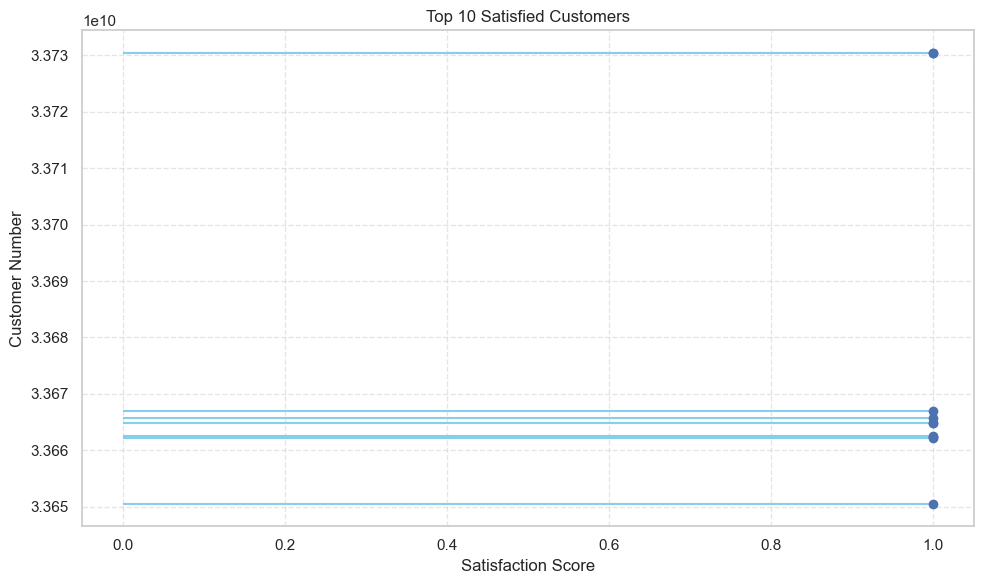

In [90]:
plt.figure(figsize=(10, 6))
plt.hlines(y=top_10_satisfied['msisdn/number'], xmin=0,
           xmax=top_10_satisfied['satisfaction_score'], color='skyblue')
plt.plot(top_10_satisfied['satisfaction_score'],
         top_10_satisfied['msisdn/number'], "o")
plt.title('Top 10 Satisfied Customers')
plt.xlabel('Satisfaction Score')
plt.ylabel('Customer Number')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Heatmap of Top 10 Satisfaction Scores

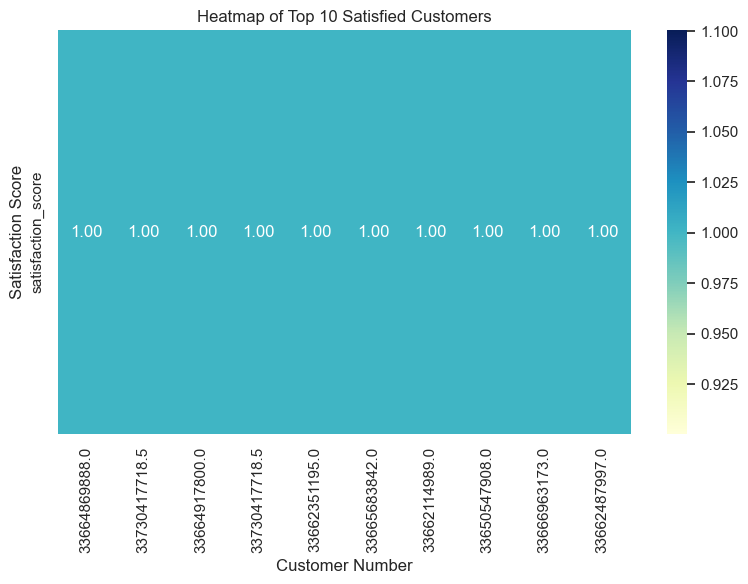

In [93]:
plt.figure(figsize=(8, 6))
heatmap_data = top_10_satisfied.set_index('msisdn/number').T
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Heatmap of Top 10 Satisfied Customers")
plt.xlabel("Customer Number")
plt.ylabel("Satisfaction Score")
plt.tight_layout()
plt.show()


# Regression Model to Predict Satisfaction

In [61]:
# Features for prediction 
features = engagement_cols + experience_cols
target = 'satisfaction_score'

# Prepare data
X = df_scaled[features]
y = df_scaled[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"\nMAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


MAE: 0.0490
R² Score: 0.9538


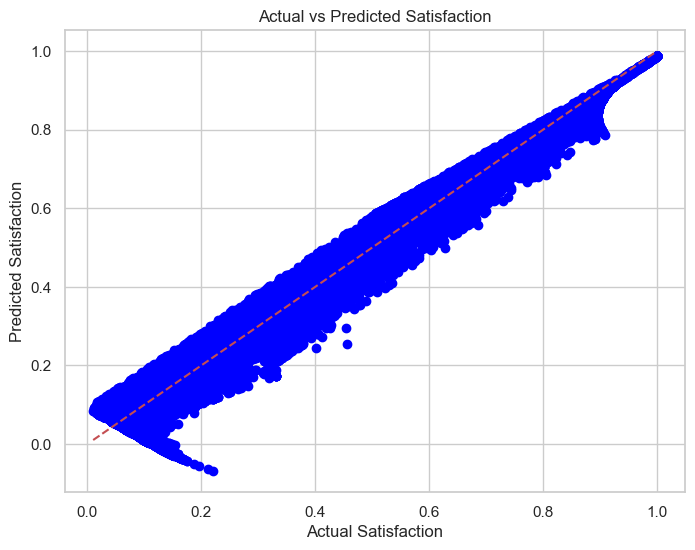

In [95]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Satisfaction')
plt.ylabel('Predicted Satisfaction')
plt.title('Actual vs Predicted Satisfaction')
plt.show()


# K-Means Clustering (k=2) on Engagement & Experience Scores

In [64]:
kmeans_2 = KMeans(n_clusters=2, random_state=42)
df_scaled['satisfaction_cluster'] = kmeans_2.fit_predict(df_scaled[['engagement_score', 'experience_score']])

# Check cluster distribution
print("\nCluster Counts:\n", df_scaled['satisfaction_cluster'].value_counts())



Cluster Counts:
 satisfaction_cluster
0    107431
1     42570
Name: count, dtype: int64


# Aggregate Scores per Cluster

In [67]:
cluster_aggregates = df_scaled.groupby('satisfaction_cluster')[['satisfaction_score', 'experience_score']].mean()

print("\nAverage Scores per Cluster:")
print(cluster_aggregates)



Average Scores per Cluster:
                      satisfaction_score  experience_score
satisfaction_cluster                                      
0                               0.124317          0.204077
1                               0.669565          0.648244


# Export to MySQL

In [74]:
# MySQL connection
conn = mysql.connector.connect(
    host='localhost',
    user='root',        
    password='1234',
    database='telecom_db'  
)
cursor = conn.cursor()

# Create table 
cursor.execute("""
CREATE TABLE IF NOT EXISTS satisfaction_scores (
    user_id VARCHAR(50),
    engagement_score FLOAT,
    experience_score FLOAT,
    satisfaction_score FLOAT,
    satisfaction_cluster INT
)
""")

# Insert data
insert_query = """
INSERT INTO satisfaction_scores (user_id, engagement_score, experience_score, satisfaction_score, satisfaction_cluster)
VALUES (%s, %s, %s, %s, %s)
"""

data_to_insert = df_scaled[['msisdn/number', 'engagement_score', 'experience_score', 'satisfaction_score', 'satisfaction_cluster']].values.tolist()
cursor.executemany(insert_query, data_to_insert)
conn.commit()

# Verify insertion
cursor.execute("SELECT * FROM satisfaction_scores LIMIT 10")
results = cursor.fetchall()

print("\nSample Inserted Rows:")
for row in results:
    print(row)

# Close connection
cursor.close()
conn.close()


Sample Inserted Rows:
('33664962239.0', 0.0166981, 0.0387346, 0.0277163, 0)
('33681854413.0', 0.0171794, 0.253666, 0.135422, 0)
('33730417718.5', 0.0176992, 0.0631408, 0.04042, 0)
('33730417718.5', 0.0162937, 0.0631408, 0.0397173, 0)
('33699795932.0', 0.0176992, 0.0631408, 0.04042, 0)
('33668185951.0', 0.0156006, 0.0631408, 0.0393707, 0)
('33665368271.0', 0.0168328, 0.613799, 0.315316, 0)
('33730417718.5', 0.0612188, 0.592149, 0.326684, 0)
('33698743617.0', 0.016159, 0.0631408, 0.0396499, 0)
('33659219748.0', 0.104846, 0.575802, 0.340324, 0)
